# The purpose of this notebook is to calculate the Weight of Evidence (WOE) and Information Value (IV) for each predictor variable in our cleaned dataset.

### WOE and IV help us identify which variables have the strongest predictive power in distinguishing good (non-default) vs bad (default) borrowers for our Elder-Care Support Loan credit scorecard.

In [ ]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 120)

DATA_PATH = Path("merged_applicant_and_bureau_cleaned_2.csv")   
OUT_DIR = Path("woe_iv_outputs")                              # local subfolder for outputs
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
TARGET_COL = "TARGET"   # 0 = good, 1 = bad 

In [4]:
# Load your cleaned dataset
df = pd.read_csv(DATA_PATH)

# Quick checks
print("Shape:", df.shape)
print("Columns:", df.columns.tolist()[:20])  # show first 20 columns
df[TARGET_COL].value_counts(dropna=False)
df.head()


Shape: (254358, 28)
Columns: ['SK_ID_CURR', 'TARGET', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 'OCCUPATION_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'AGE', 'AMT_CREDIT_SUM_sum', 'AMT_CREDIT_SUM_DEBT_sum', 'AMT_CREDIT_SUM_OVERDUE_max', 'CREDIT_DAY_OVERDUE_max', 'CNT_CREDIT_PROLONG_sum', 'CREDIT_ACTIVE_Active']


,SK_ID_CURR,TARGET,NAME_INCOME_TYPE,NAME_FAMILY_STATUS,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,OCCUPATION_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,AGE,AMT_CREDIT_SUM_sum,AMT_CREDIT_SUM_DEBT_sum,AMT_CREDIT_SUM_OVERDUE_max,CREDIT_DAY_OVERDUE_max,CNT_CREDIT_PROLONG_sum,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Closed,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Microloan,CREDIT_TYPE_Unknown type of loan,CREDIT_TYPE_Another type of loan,DEBT_RATIO,OVERDUE_RATIO
0,100003,0,State servant,Married,0,270000.0,1293502.5,35698.5,1129500.0,-1188.0,Core staff,N,N,45.931507,94900.5,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100004,0,Working,Single / not married,0,67500.0,135000.0,6750.0,135000.0,-225.0,Laborers,Y,Y,52.180822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100006,0,Working,Civil marriage,0,135000.0,312682.5,29686.5,297000.0,-3039.0,Laborers,N,Y,52.068493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100007,0,Working,Single / not married,0,121500.0,513000.0,21865.5,513000.0,-3038.0,Core staff,N,Y,54.608219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100008,0,State servant,Married,0,99000.0,490495.5,27517.5,454500.0,-1588.0,Laborers,N,Y,46.413699,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Function takes in a data frame for a variable with columns: variable values, 'TARGET' values, bin range corresponding to varaible value.

In [5]:
def woe_iv(data):
    working_data = data.copy() 
    working_data['Bin_Range'] = working_data['Bin_Range'].astype('object')
    working_data['Bin_Range'].fillna('Missing', inplace=True)
    
    variable_data = pd.DataFrame()
    variable_data['Bin_Range'] = working_data.groupby(by='Bin_Range', as_index=False).count()['Bin_Range']
    variable_data['Count'] = working_data.groupby(by='Bin_Range', as_index=False).count()['TARGET']
    variable_data['Events'] = working_data.groupby(by='Bin_Range', as_index=False).sum()['TARGET']
    variable_data['Non_Events'] = variable_data['Count'] - variable_data['Events']
    
    # Add small constant to avoid division by zero
    variable_data['%_of_Events'] = (variable_data['Events'] + 0.5) / (sum(variable_data['Events']) + 0.5 * len(variable_data))
    variable_data['%_of_Non_Events'] = (variable_data['Non_Events'] + 0.5) / (sum(variable_data['Non_Events']) + 0.5 * len(variable_data))
    
    variable_data['WOE'] = np.log(variable_data['%_of_Non_Events'] / variable_data['%_of_Events'])
    variable_data['IV'] = (variable_data['%_of_Non_Events'] - variable_data['%_of_Events']) * variable_data['WOE']
    variable_data['total_IV'] = variable_data['IV'].sum()
    
    return variable_data

# # test the function
# df_bin_data = df.loc[:,('AMT_CREDIT', 'TARGET')].copy()
# df_bin_data['Bin_Range'] = pd.qcut(df['AMT_CREDIT'], q=20)
# woe_iv(df_bin_data)

# Function to calculate WOE, IV and plot IV

In [6]:
# create IV calc and WOE plotting function
def woe_iv_plot(data, variable_name):
    variable_data = woe_iv(data)
    print('IV for', variable_name, 'with', variable_data.shape[0], 'bins:', round(variable_data.loc[0,'total_IV'],4))
    ffig, ax1 = plt.subplots(figsize=(20,6))

    # if 'missing' bin, do not include in plot
    if variable_data['Bin_Range'].isin(['Missing']).sum() > 0:
        sns.lineplot(data = variable_data['WOE'].iloc[0:-1], marker='o', sort = False, ax=ax1)
    else:
        sns.lineplot(data = variable_data['WOE'], marker='o', sort = False, ax=ax1)
    plt.xticks(rotation=45)

    # if 'missing' bin, create the scatter plot to plot the Missing WOE data point
    if variable_data['Bin_Range'].isin(['Missing']).sum() > 0: 
        last_point = len(variable_data['WOE']) - 1
        scatter_plot = sns.scatterplot(x=[last_point], y=[variable_data['WOE'][last_point]], color='b', s=30, ax=ax1)
    
    ax2 = ax1.twinx()
    
    # Calculate percentages instead of using raw counts
    total_count = variable_data['Count'].sum()
    variable_data['Percent'] = (variable_data['Count'] / total_count) * 100
        
    # plot the bin percentages instead of counts
    sns.barplot(x = variable_data['Bin_Range'], y = variable_data['Percent'], alpha=0.5, ax = ax2, color = 'deepskyblue')
    
    # Update y-axis label to reflect percentage
    ax2.set_ylabel('Percent of Observations (%)')
    
    plt.title("WOE plot for " + variable_name)
    plt.show()
    

C:\Users\johnt\AppData\Local\Temp\ipykernel_48212\1750641458.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
C:\Users\johnt\AppData\Local\Temp\ipykernel_48212\3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

IV for AMT_CREDIT with 5 bins: 0.0402


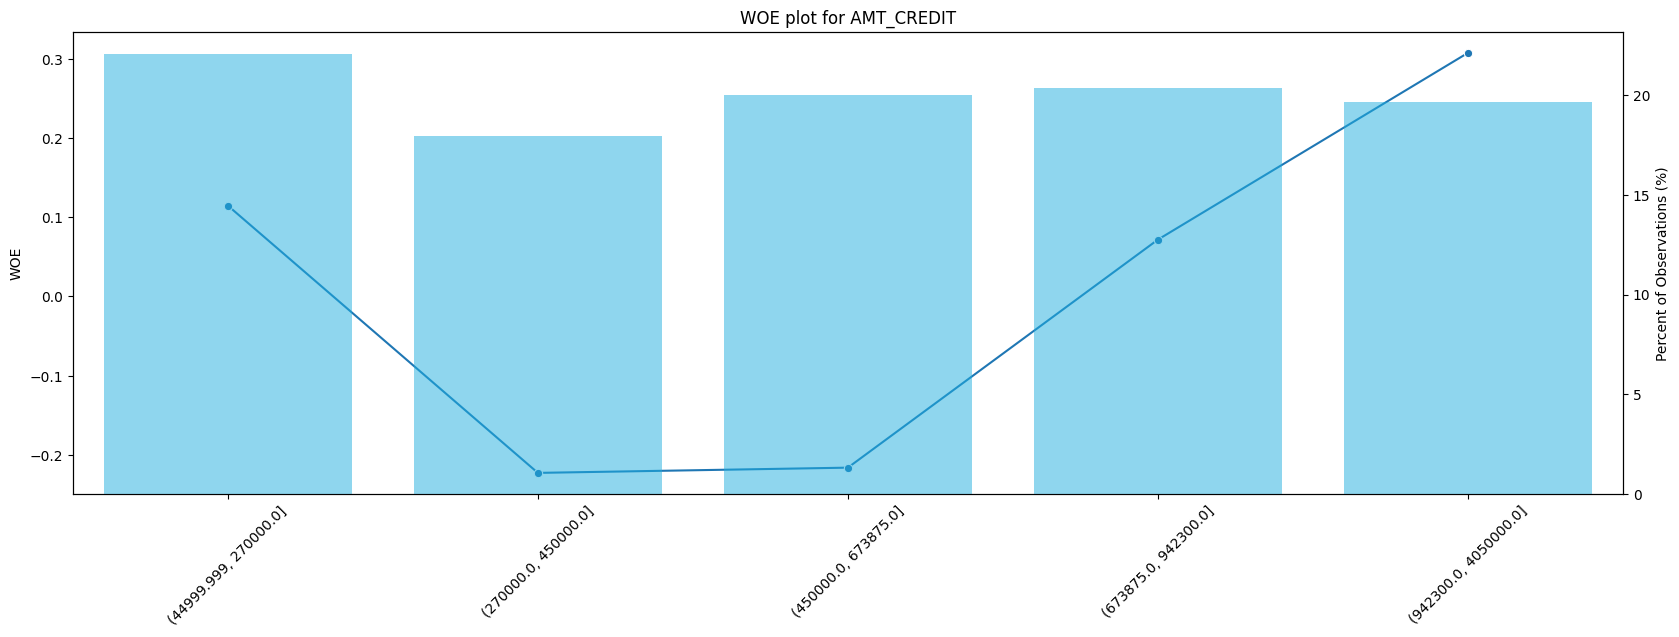

In [7]:
# test the function - create a copy first
variable = 'AMT_CREDIT'
woe_bin_data = df.loc[:,(variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = pd.qcut(df[variable], q=5)
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
woe_iv_plot(woe_bin_data, variable)

# Coarse classing Uses pd.cut to do coarse classing using equal width bins to calcualte IV and plot WOE

C:\Users\johnt\AppData\Local\Temp\ipykernel_48212\3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  working_data['Bin_Range'].fillna('Missing', inplace=True)


IV for AMT_CREDIT with 6 bins: 0.0471


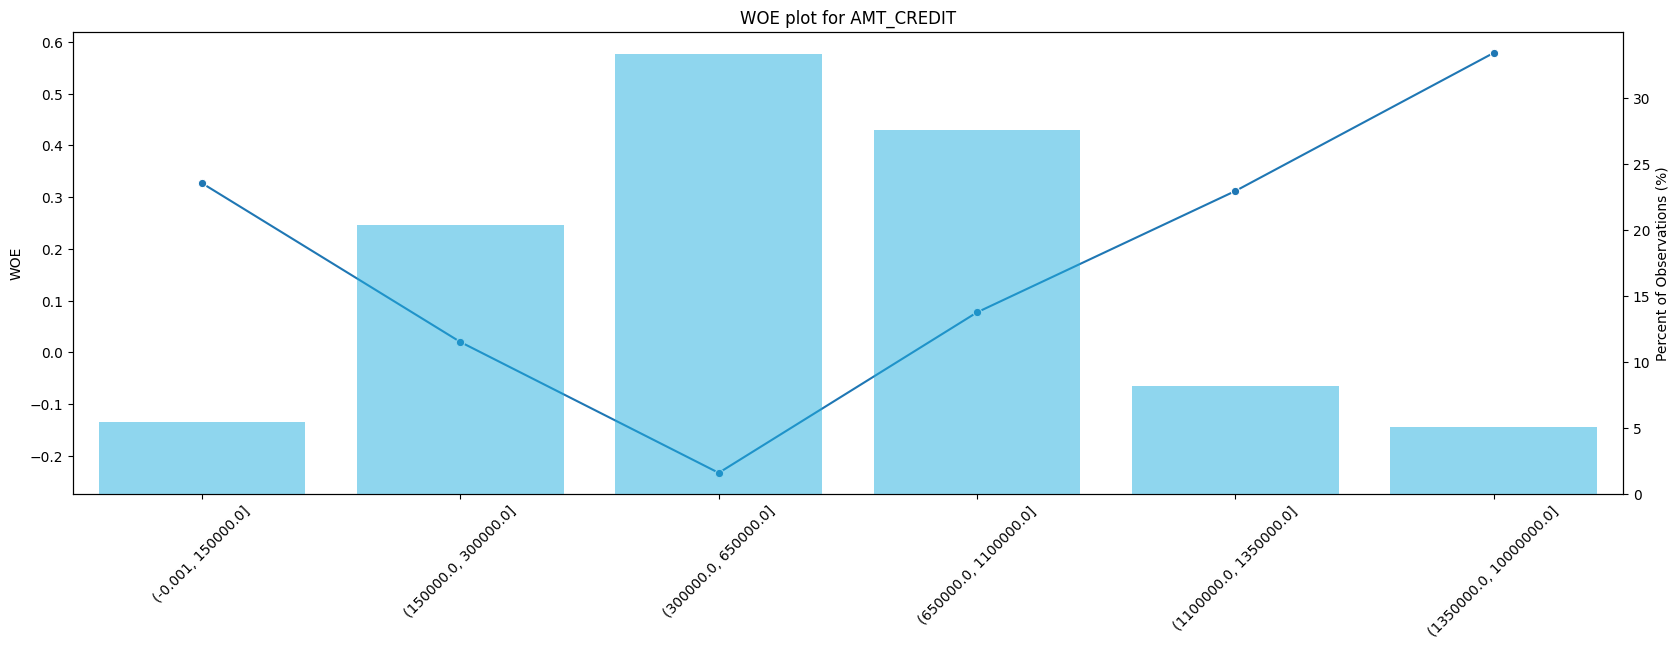

In [8]:
# sample code

bin_edges = [0, 150000, 300000, 650000, 1100000, 1350000, 10000000]
variable = 'AMT_CREDIT'

# create groupings based on specified bin edges
df['Bin_Range'] = pd.cut(df[variable], bins = bin_edges, include_lowest= True)
df['Bin_Range'].value_counts().sort_index()

woe_iv_plot(df, variable)


### DAYS_EMPLOYED

C:\Users\johnt\AppData\Local\Temp\ipykernel_48212\3718830670.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
C:\Users\johnt\AppData\Local\Temp\ipykernel_48212\3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

IV for DAYS_EMPLOYED with 6 bins: 0.0942


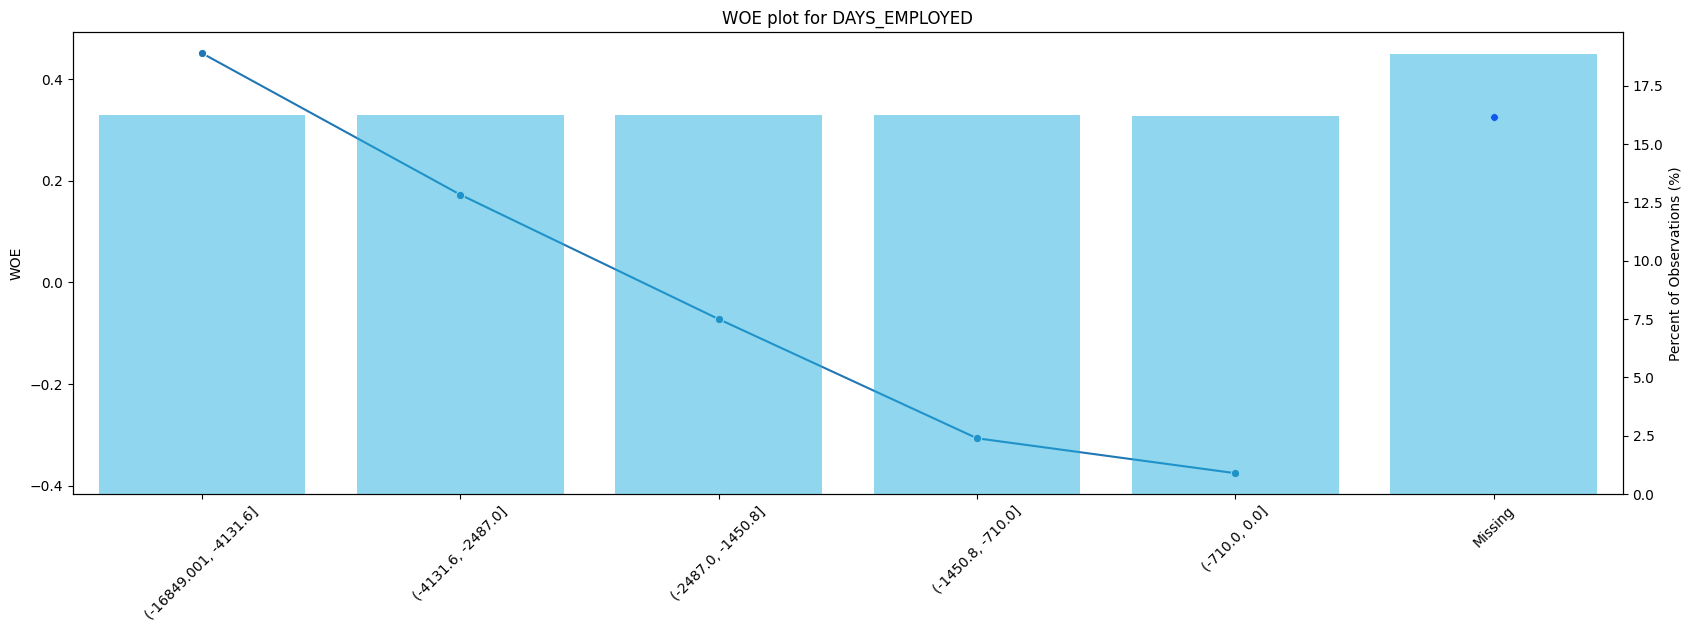

In [9]:
# test the function - create a copy first
variable = 'DAYS_EMPLOYED'
woe_bin_data = df.loc[:,(variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = pd.qcut(df[variable], q=5)
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
woe_iv_plot(woe_bin_data, variable)

C:\Users\johnt\AppData\Local\Temp\ipykernel_48212\1625962404.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Bin_Range'] = pd.cut(df[variable], bins = bin_edges, include_lowest= True)
C:\Users\johnt\AppData\Local\Temp\ipykernel_48212\1773856854.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the orig

IV for DAYS_EMPLOYED with 5 categories: 0.0454


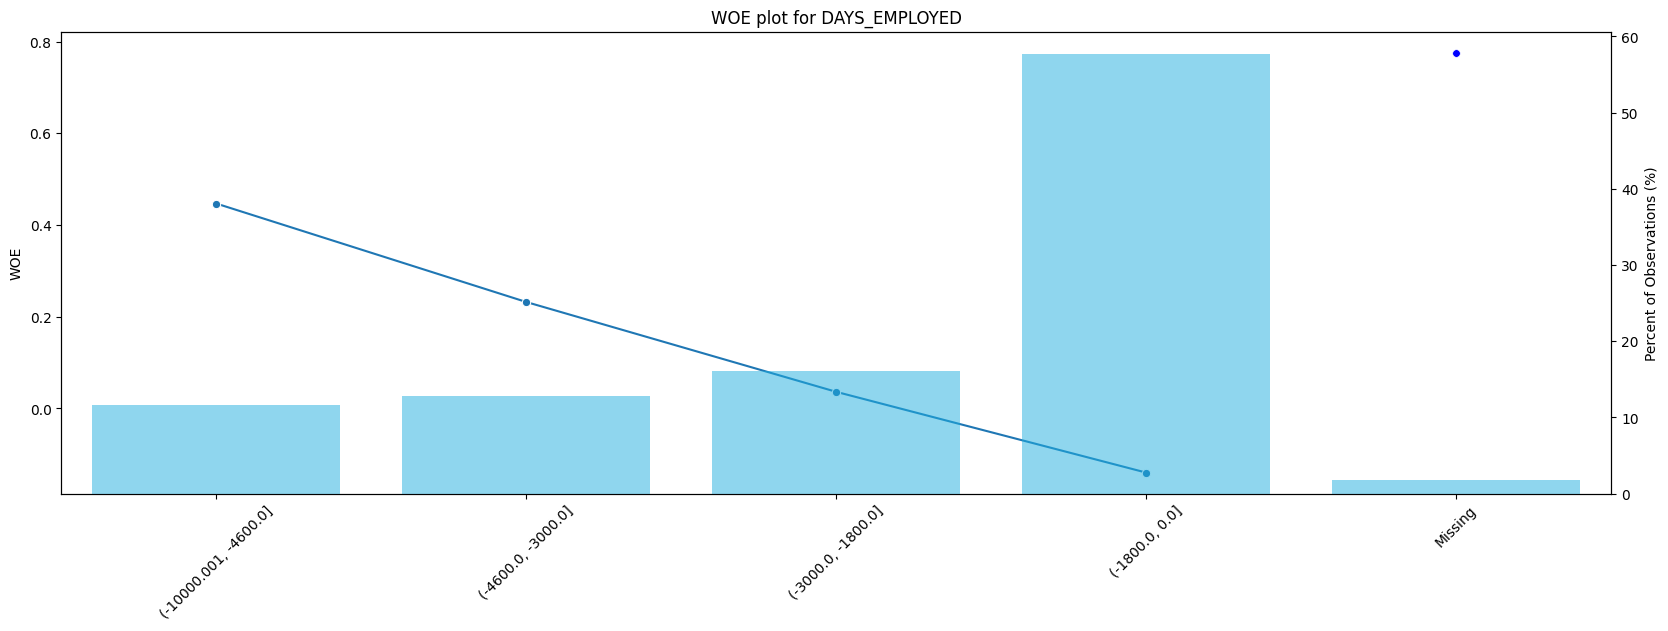

In [34]:
# sample code

bin_edges = [-10000,-4600.0, -3000.0, -1800.0, 0, 1000]
variable = 'DAYS_EMPLOYED'

# create groupings based on specified bin edges
df['Bin_Range'] = pd.cut(df[variable], bins = bin_edges, include_lowest= True)
df['Bin_Range'].value_counts().sort_index()

woe_iv_plot(df, variable)


### DEBT_RATIO

C:\Users\johnt\AppData\Local\Temp\ipykernel_48212\1308165285.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
C:\Users\johnt\AppData\Local\Temp\ipykernel_48212\3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

IV for DEBT_RATIO with 6 bins: 0.0525


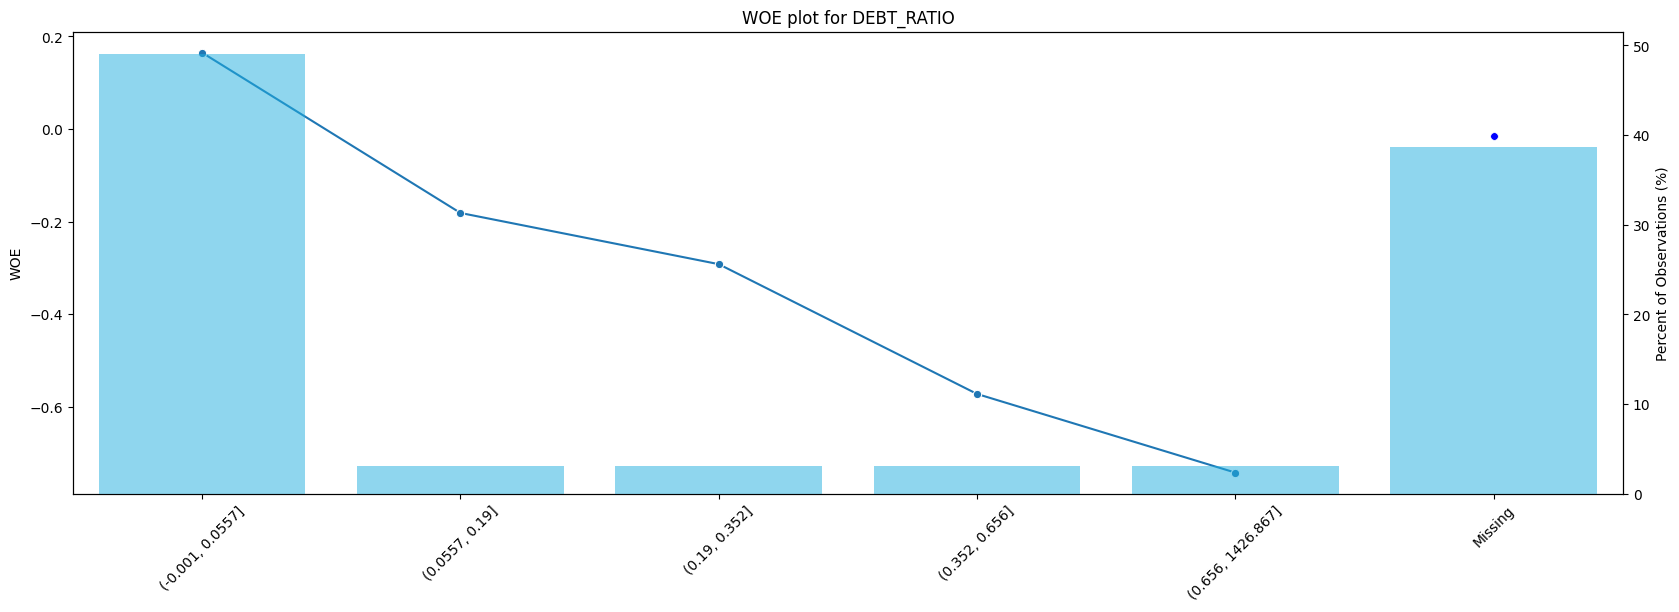

In [11]:
# test the function - create a copy first
variable = 'DEBT_RATIO'
woe_bin_data = df.loc[:,(variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = pd.qcut(df[variable], q=20, duplicates='drop')
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
woe_iv_plot(woe_bin_data, variable)

C:\Users\johnt\AppData\Local\Temp\ipykernel_48212\3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  working_data['Bin_Range'].fillna('Missing', inplace=True)


IV for DEBT_RATIO with 4 bins: 0.0517


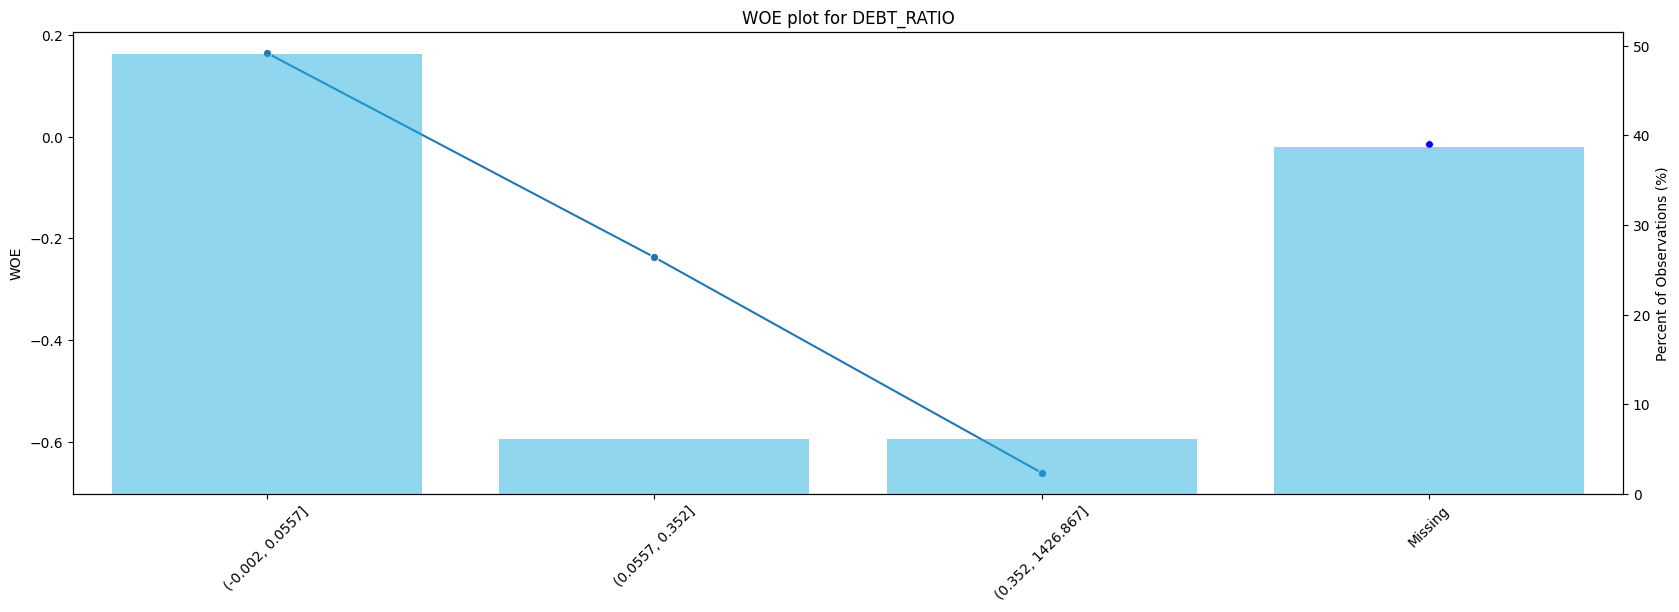

In [12]:
# sample code

bin_edges = [-0.001, 0.0557, 0.352, 1426.867]
variable = 'DEBT_RATIO'

# create groupings based on specified bin edges
df['Bin_Range'] = pd.cut(df[variable], bins = bin_edges, include_lowest= True)
df['Bin_Range'].value_counts().sort_index()

woe_iv_plot(df, variable)


### AMT_CREDIT_SUM_DEBT_sum

C:\Users\johnt\AppData\Local\Temp\ipykernel_48212\3052190614.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
C:\Users\johnt\AppData\Local\Temp\ipykernel_48212\3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

IV for AMT_CREDIT_SUM_DEBT_sum with 6 bins: 0.0479


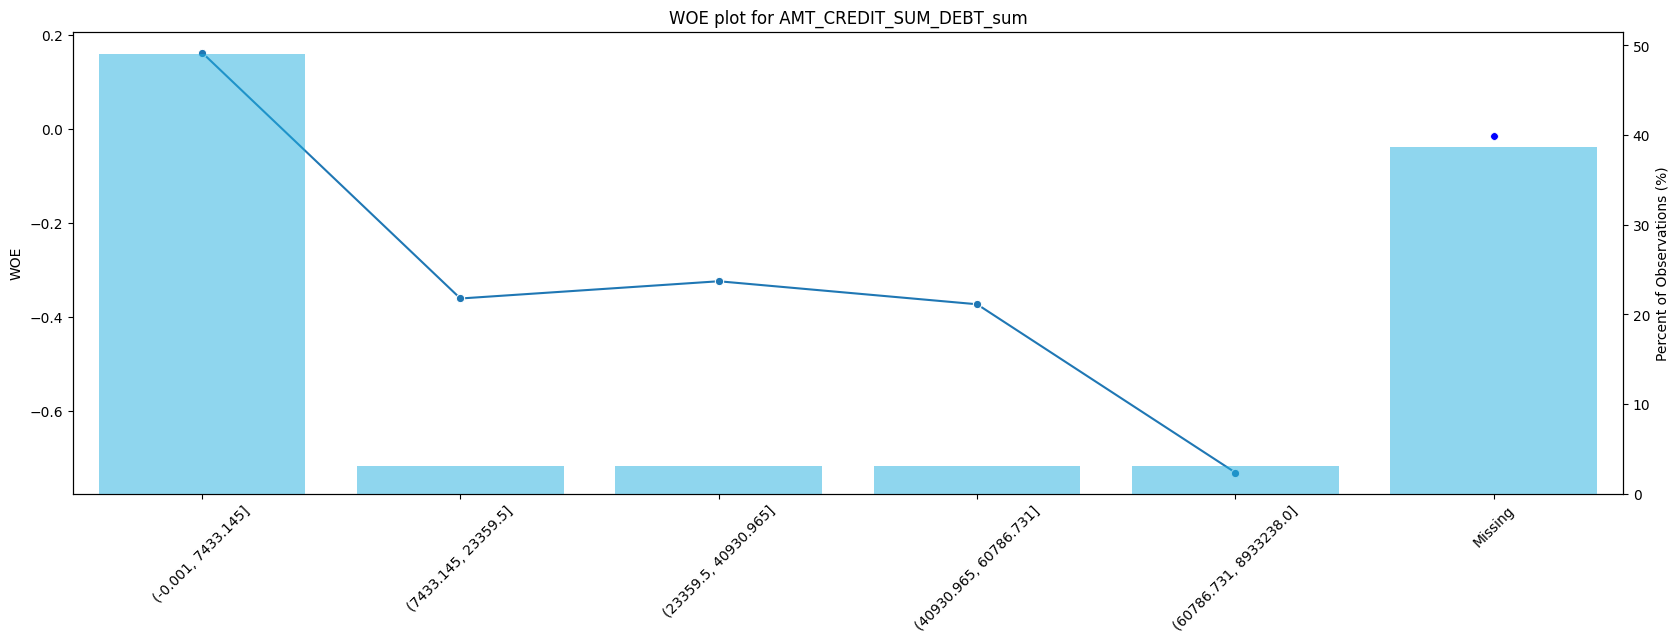

In [13]:
# test the function - create a copy first
variable = 'AMT_CREDIT_SUM_DEBT_sum'
woe_bin_data = df.loc[:,(variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = pd.qcut(df[variable], q=20, duplicates="drop")
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
woe_iv_plot(woe_bin_data, variable)

C:\Users\johnt\AppData\Local\Temp\ipykernel_48212\3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  working_data['Bin_Range'].fillna('Missing', inplace=True)


IV for AMT_CREDIT_SUM_DEBT_sum with 5 bins: 0.0483


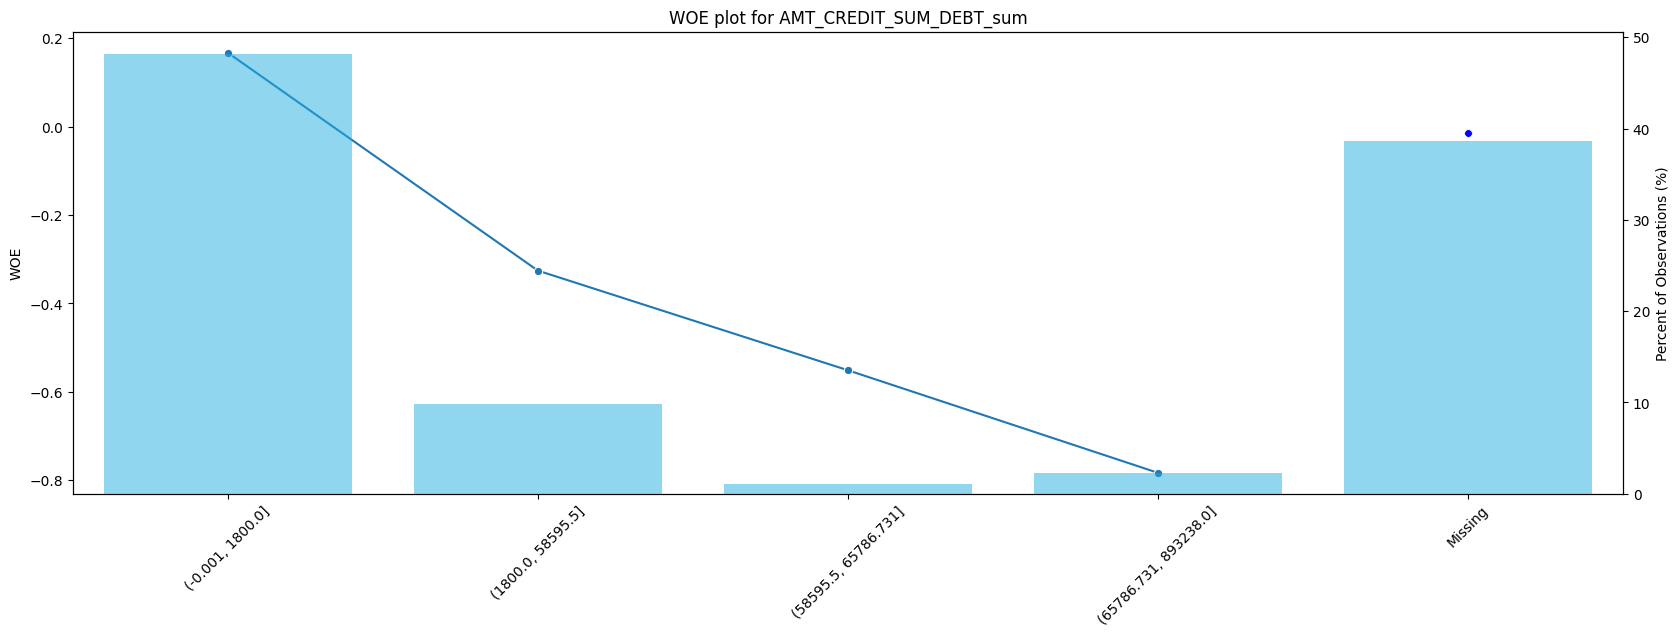

In [14]:
# sample code

bin_edges = [0, 1800, 58595.5, 65786.731, 893238.0]
variable = 'AMT_CREDIT_SUM_DEBT_sum'

# create groupings based on specified bin edges
df['Bin_Range'] = pd.cut(df[variable], bins = bin_edges, include_lowest= True)
df['Bin_Range'].value_counts().sort_index()

woe_iv_plot(df, variable)


### AGE

C:\Users\johnt\AppData\Local\Temp\ipykernel_48212\2776209989.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
C:\Users\johnt\AppData\Local\Temp\ipykernel_48212\3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

IV for AGE with 6 bins: 0.0539


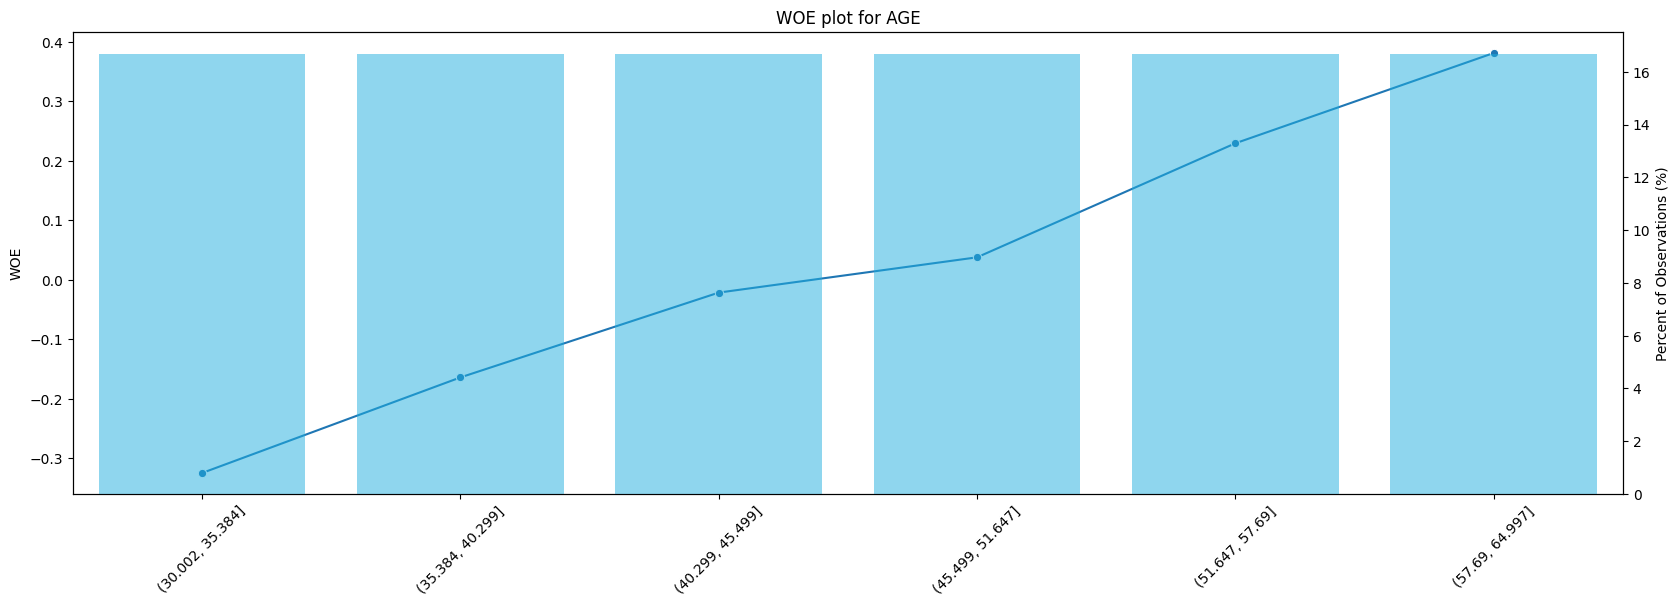

In [15]:
# test the function - create a copy first
variable = 'AGE'
woe_bin_data = df.loc[:,(variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = pd.qcut(df[variable], q=6)
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
woe_iv_plot(woe_bin_data, variable)

C:\Users\johnt\AppData\Local\Temp\ipykernel_48212\3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  working_data['Bin_Range'].fillna('Missing', inplace=True)


IV for AGE with 4 bins: 0.0499


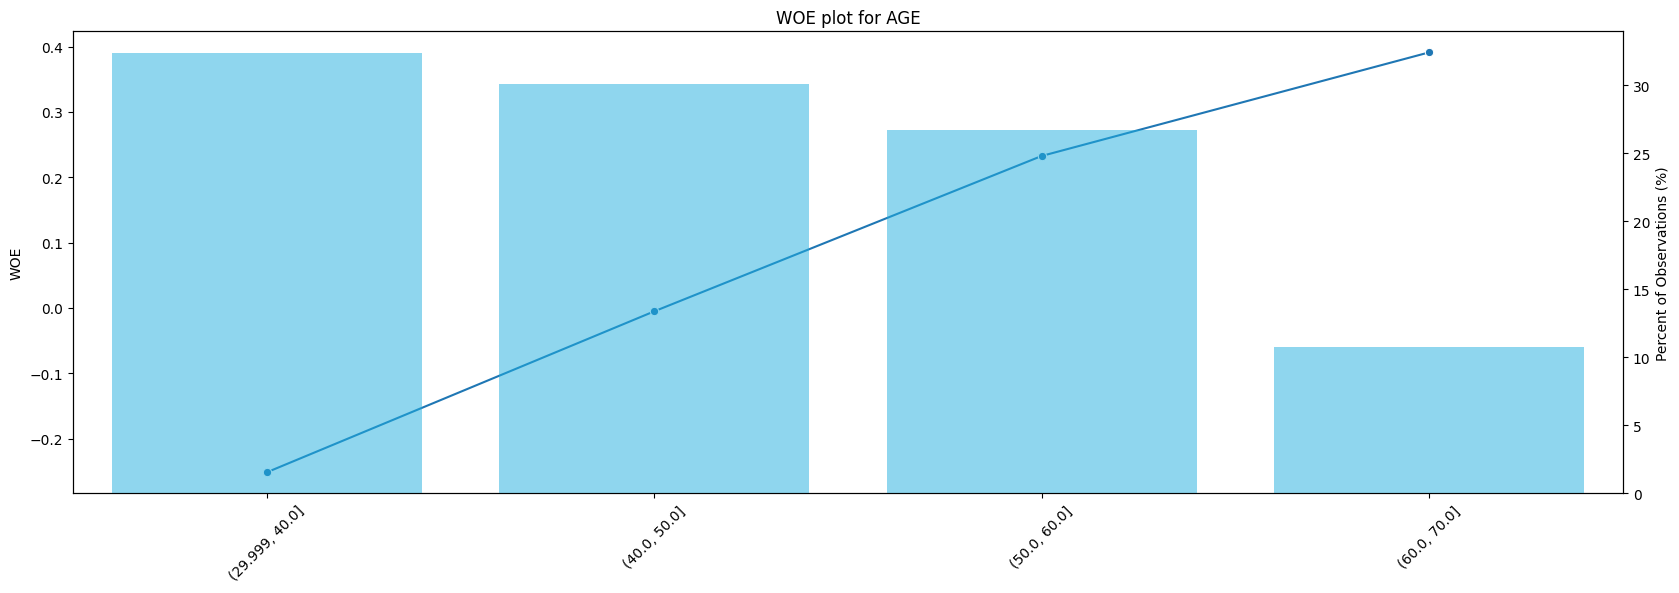

In [16]:
# sample code

bin_edges = [30, 40, 50, 60,  70]
variable = 'AGE'

# create groupings based on specified bin edges
df['Bin_Range'] = pd.cut(df[variable], bins = bin_edges, include_lowest= True)
df['Bin_Range'].value_counts().sort_index()

woe_iv_plot(df, variable)


### CREDIT_ACTIVE_Active

C:\Users\johnt\AppData\Local\Temp\ipykernel_48212\446180054.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
C:\Users\johnt\AppData\Local\Temp\ipykernel_48212\3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


IV for CREDIT_ACTIVE_Active with 5 bins: 0.0191


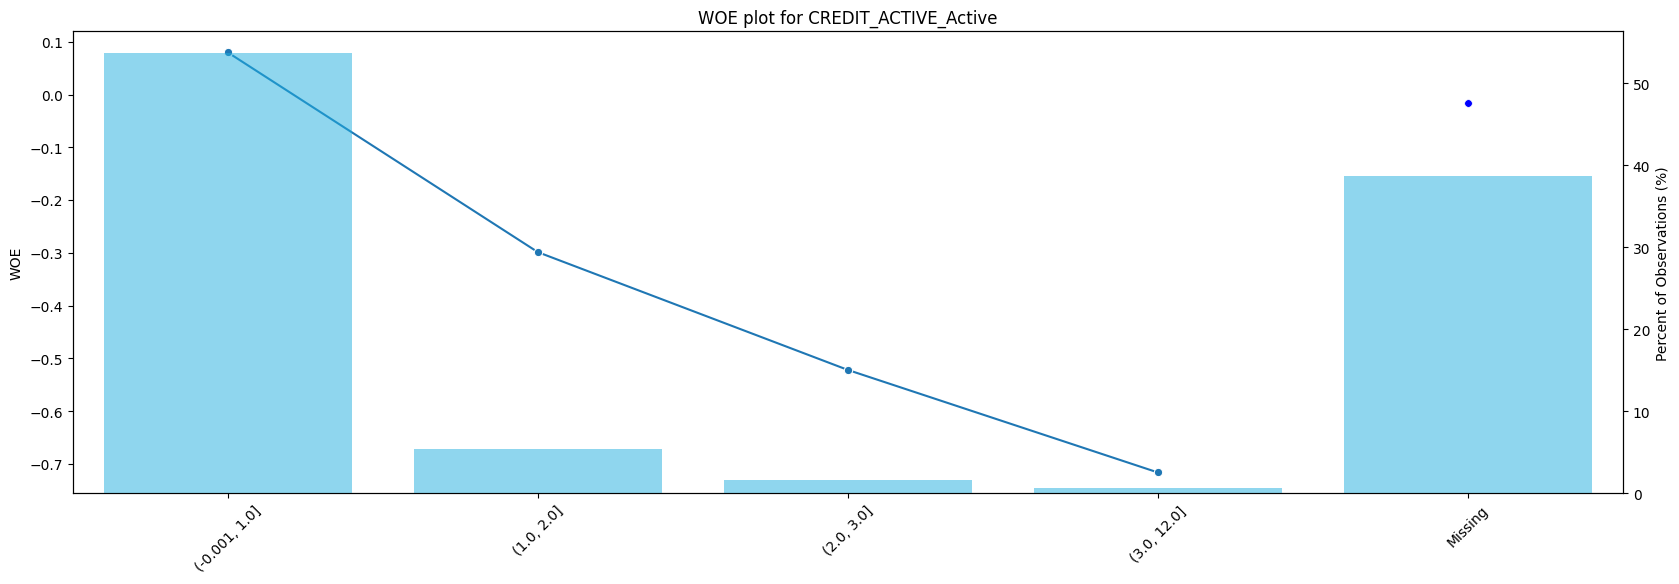

In [17]:
# test the function - create a copy first
variable = 'CREDIT_ACTIVE_Active'
woe_bin_data = df.loc[:,(variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = pd.qcut(df[variable], q=30, duplicates='drop')
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
woe_iv_plot(woe_bin_data, variable)

C:\Users\johnt\AppData\Local\Temp\ipykernel_48212\3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  working_data['Bin_Range'].fillna('Missing', inplace=True)


IV for CREDIT_ACTIVE_Active with 4 bins: 0.0221


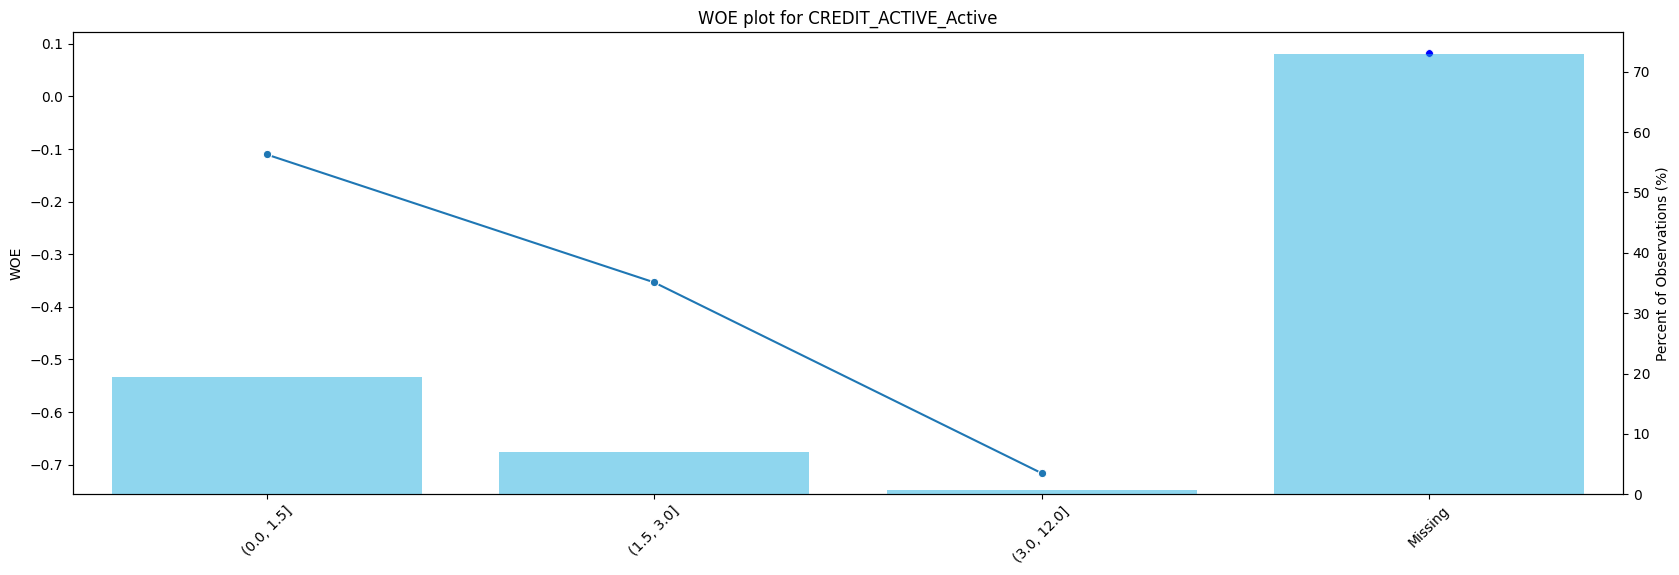

In [18]:
# sample code

bin_edges = [0.001, 1.5, 3.0, 12.0]
variable = 'CREDIT_ACTIVE_Active'

# create groupings based on specified bin edges
df['Bin_Range'] = pd.cut(df[variable], bins = bin_edges, include_lowest= True)
df['Bin_Range'].value_counts().sort_index()

woe_iv_plot(df, variable)


### AMT_GOODS_PRICE	

### AMT_ANNUITY		

### CREDIT_ACTIVE_Closed	

### CREDIT_TYPE_Credit card		

### FLAG_OWN_CAR	

### CREDIT_TYPE_Microloan	

# Categorical
### OCCUPATION_TYPE

C:\Users\johnt\AppData\Local\Temp\ipykernel_48212\1773856854.py:61: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
C:\Users\johnt\AppData\Local\Temp\ipykernel_48212\1773856854.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

IV for OCCUPATION_TYPE with 19 categories: 0.0799


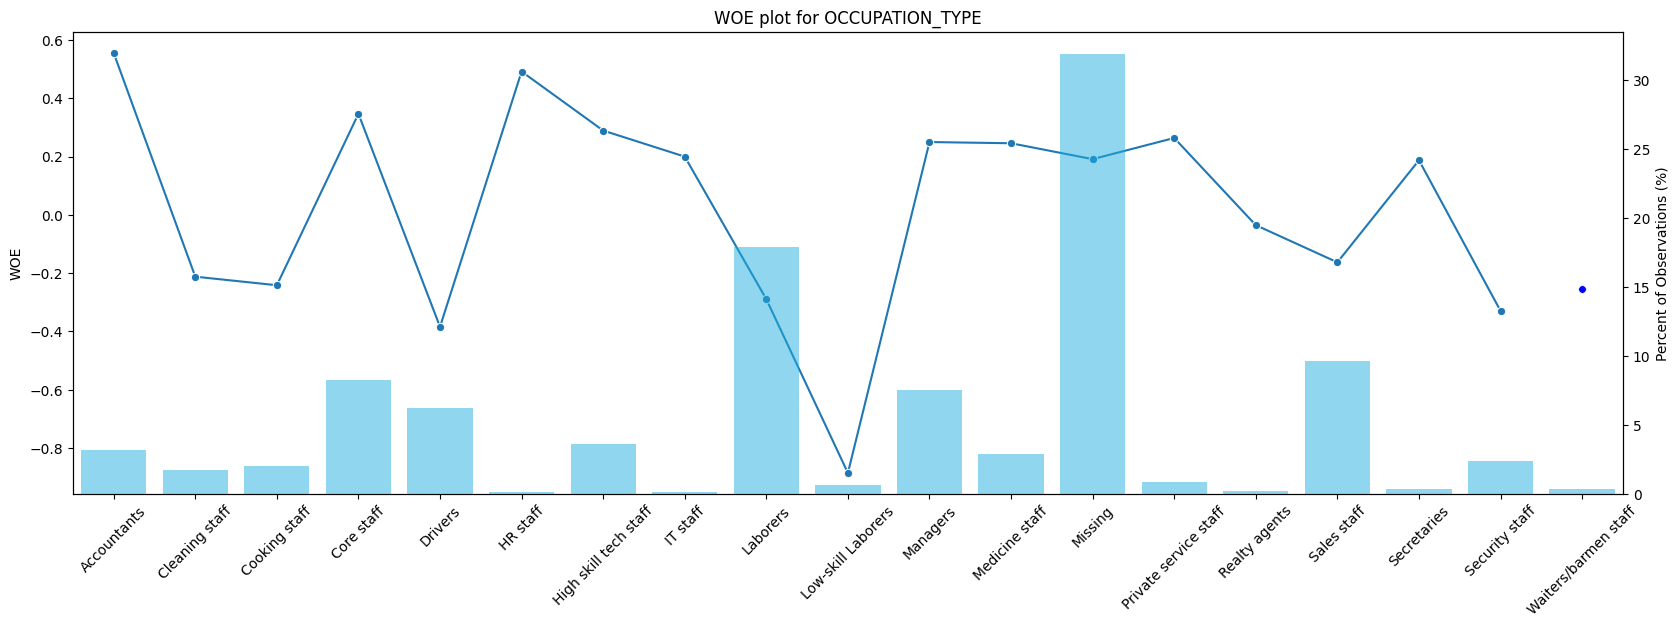

In [19]:
def woe_iv(data):
    working_data = data.copy() 
    working_data['Bin_Range'] = working_data['Bin_Range'].astype('object')
    working_data['Bin_Range'].fillna('Missing', inplace=True)
    
    variable_data = pd.DataFrame()
    variable_data['Bin_Range'] = working_data.groupby(by='Bin_Range', as_index=False).count()['Bin_Range']
    variable_data['Count'] = working_data.groupby(by='Bin_Range', as_index=False).count()['TARGET']
    variable_data['Events'] = working_data.groupby(by='Bin_Range', as_index=False).sum()['TARGET']
    variable_data['Non_Events'] = variable_data['Count'] - variable_data['Events']
    
    # Add small constant to avoid division by zero
    variable_data['%_of_Events'] = (variable_data['Events'] + 0.5) / (sum(variable_data['Events']) + 0.5 * len(variable_data))
    variable_data['%_of_Non_Events'] = (variable_data['Non_Events'] + 0.5) / (sum(variable_data['Non_Events']) + 0.5 * len(variable_data))
    
    variable_data['WOE'] = np.log(variable_data['%_of_Non_Events'] / variable_data['%_of_Events'])
    variable_data['IV'] = (variable_data['%_of_Non_Events'] - variable_data['%_of_Events']) * variable_data['WOE']
    variable_data['total_IV'] = variable_data['IV'].sum()
    
    return variable_data


# create IV calc and WOE plotting function
def woe_iv_plot(data, variable_name):
    variable_data = woe_iv(data)
    print('IV for', variable_name, 'with', variable_data.shape[0], 'categories:', round(variable_data.loc[0,'total_IV'],4))
    ffig, ax1 = plt.subplots(figsize=(20,6))

    # if 'missing' bin, do not include in plot
    if variable_data['Bin_Range'].isin(['Missing']).sum() > 0:
        sns.lineplot(data = variable_data['WOE'].iloc[0:-1], marker='o', sort = False, ax=ax1)
    else:
        sns.lineplot(data = variable_data['WOE'], marker='o', sort = False, ax=ax1)
    plt.xticks(rotation=45)

    # if 'missing' bin, create the scatter plot to plot the Missing WOE data point
    if variable_data['Bin_Range'].isin(['Missing']).sum() > 0: 
        last_point = len(variable_data['WOE']) - 1
        scatter_plot = sns.scatterplot(x=[last_point], y=[variable_data['WOE'][last_point]], color='b', s=30, ax=ax1)
    
    ax2 = ax1.twinx()
    
    # Calculate percentages instead of using raw counts
    total_count = variable_data['Count'].sum()
    variable_data['Percent'] = (variable_data['Count'] / total_count) * 100
        
    # plot the bin percentages instead of counts
    sns.barplot(x = variable_data['Bin_Range'], y = variable_data['Percent'], alpha=0.5, ax = ax2, color = 'deepskyblue')
    
    # Update y-axis label to reflect percentage
    ax2.set_ylabel('Percent of Observations (%)')
    
    plt.title("WOE plot for " + variable_name)
    plt.show()
    
# test the function for categorical variable
variable = 'OCCUPATION_TYPE'  # Example categorical variable
woe_bin_data = df.loc[:,(variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = woe_bin_data[variable]  # Use categorical values directly instead of binning
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
woe_iv_plot(woe_bin_data, variable)

### NAME_INCOME_TYPE

C:\Users\johnt\AppData\Local\Temp\ipykernel_48212\590647377.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
C:\Users\johnt\AppData\Local\Temp\ipykernel_48212\1773856854.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


IV for NAME_INCOME_TYPE with 8 categories: 0.0467


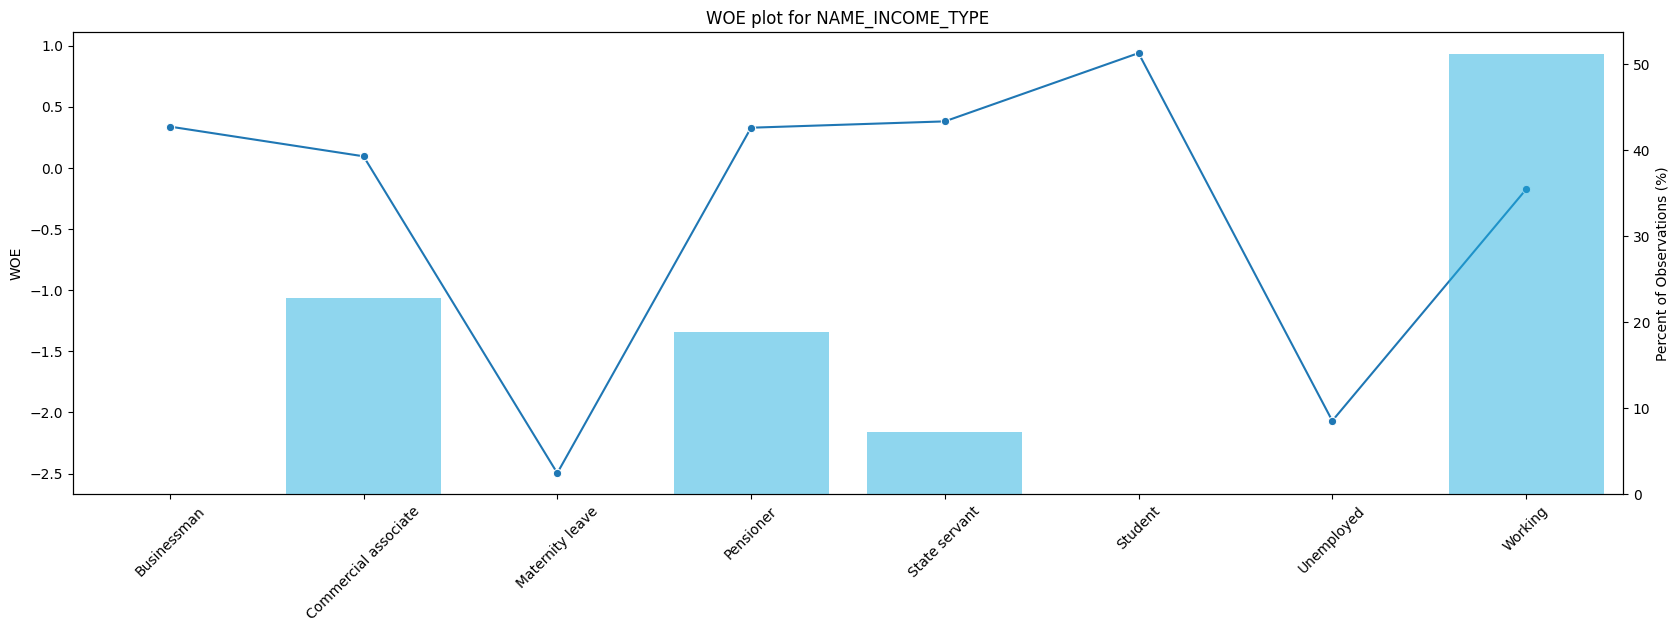

In [20]:
# test the function for categorical variable
variable = 'NAME_INCOME_TYPE'  # Example categorical variable
woe_bin_data = df.loc[:,(variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = woe_bin_data[variable]  # Use categorical values directly instead of binning
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
woe_iv_plot(woe_bin_data, variable)

### NAME_FAMILY_STATUS

C:\Users\johnt\AppData\Local\Temp\ipykernel_48212\1802753599.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
C:\Users\johnt\AppData\Local\Temp\ipykernel_48212\1773856854.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

IV for NAME_FAMILY_STATUS with 6 categories: 0.0156


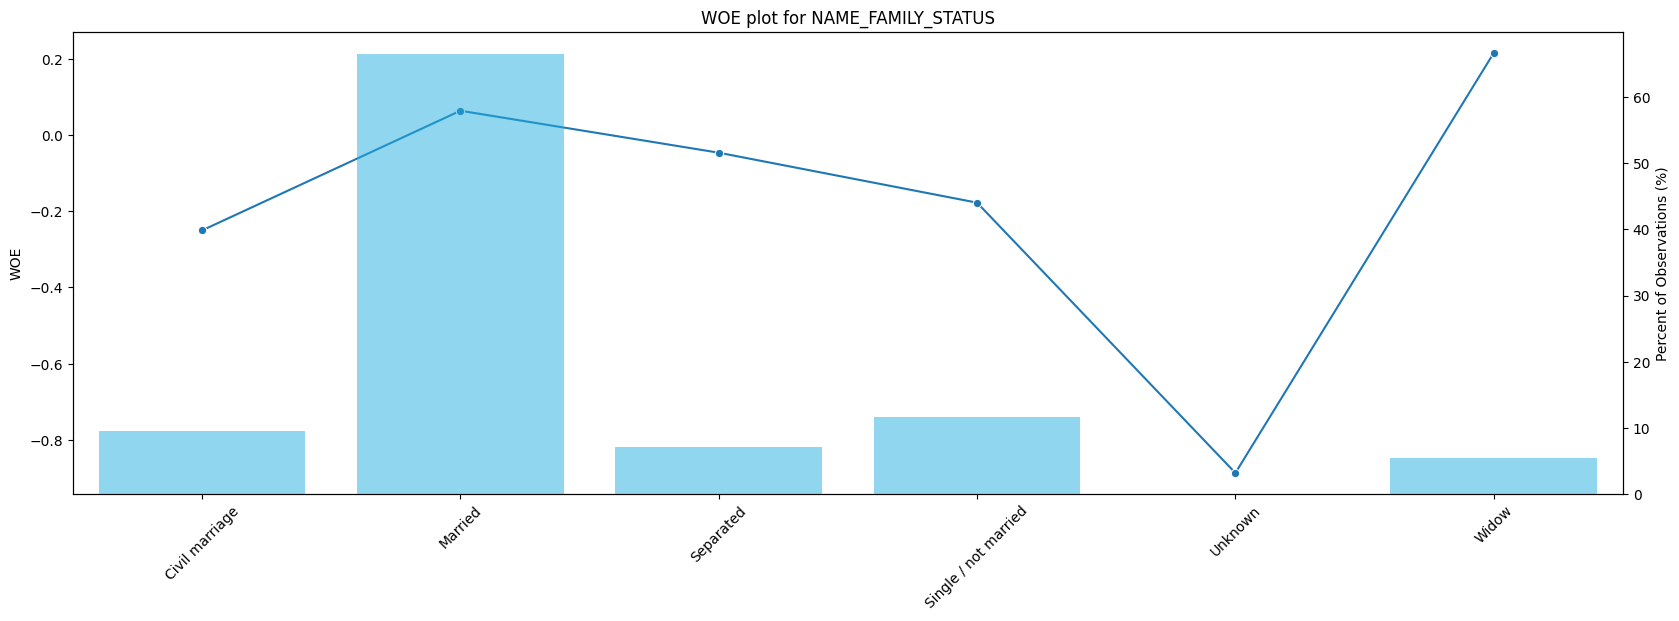

In [21]:
# test the function for categorical variable
variable = 'NAME_FAMILY_STATUS'  # Example categorical variable
woe_bin_data = df.loc[:,(variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = woe_bin_data[variable]  # Use categorical values directly instead of binning
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
woe_iv_plot(woe_bin_data, variable)

# scorecard creation but with custom bins 


In [22]:
import warnings

import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics
import scorecardpy as sc
import pprint

c:\Users\johnt\AppData\Local\Programs\Python\Python313\Lib\site-packages\scorecardpy\germancredit.py:5: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [23]:
DATA_PATH = Path("merged_applicant_and_bureau_cleaned.csv")   
df = pd.read_csv(DATA_PATH)
df

,SK_ID_CURR,TARGET,NAME_INCOME_TYPE,NAME_FAMILY_STATUS,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,OCCUPATION_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,AGE,AMT_CREDIT_SUM_sum,AMT_CREDIT_SUM_DEBT_sum,AMT_CREDIT_SUM_OVERDUE_max,CREDIT_DAY_OVERDUE_max,CNT_CREDIT_PROLONG_sum,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Closed,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Microloan,CREDIT_TYPE_Unknown type of loan,CREDIT_TYPE_Another type of loan,DEBT_RATIO,OVERDUE_RATIO
0,100003,0,State servant,Married,0,270000.0,1293502.5,35698.5,1129500.0,-1188.0,Core staff,N,N,45.931507,94900.5,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100004,0,Working,Single / not married,0,67500.0,135000.0,6750.0,135000.0,-225.0,Laborers,Y,Y,52.180822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100006,0,Working,Civil marriage,0,135000.0,312682.5,29686.5,297000.0,-3039.0,Laborers,N,Y,52.068493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100007,0,Working,Single / not married,0,121500.0,513000.0,21865.5,513000.0,-3038.0,Core staff,N,Y,54.608219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100008,0,State servant,Married,0,99000.0,490495.5,27517.5,454500.0,-1588.0,Laborers,N,Y,46.413699,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254353,456248,0,Working,Separated,0,153000.0,331920.0,16096.5,225000.0,-7258.0,Sales staff,N,Y,45.767123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254354,456252,0,Pensioner,Widow,0,72000.0,269550.0,12001.5,225000.0,NaN,NaN,N,Y,56.917808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254355,456253,0,Working,Separated,0,153000.0,677664.0,29979.0,585000.0,-7921.0,Managers,N,Y,41.002740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254356,456254,1,Commercial associate,Married,0,171000.0,370107.0,20205.0,319500.0,-4786.0,Laborers,N,Y,32.769863,45000.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
df = df[[
    "TARGET",
    "DEBT_RATIO",
    "AMT_ANNUITY",
    "NAME_INCOME_TYPE",
    "AMT_CREDIT",
    "AGE",
    "OCCUPATION_TYPE",
    "CREDIT_ACTIVE_Active",
    "DAYS_EMPLOYED"
]]
df

,TARGET,DEBT_RATIO,AMT_ANNUITY,NAME_INCOME_TYPE,AMT_CREDIT,AGE,OCCUPATION_TYPE,CREDIT_ACTIVE_Active,DAYS_EMPLOYED
0,0,0.0,35698.5,State servant,1293502.5,45.931507,Core staff,0.0,-1188.0
1,0,NaN,6750.0,Working,135000.0,52.180822,Laborers,NaN,-225.0
2,0,NaN,29686.5,Working,312682.5,52.068493,Laborers,NaN,-3039.0
3,0,NaN,21865.5,Working,513000.0,54.608219,Core staff,NaN,-3038.0
4,0,NaN,27517.5,State servant,490495.5,46.413699,Laborers,NaN,-1588.0
...,...,...,...,...,...,...,...,...,...
254353,0,NaN,16096.5,Working,331920.0,45.767123,Sales staff,NaN,-7258.0
254354,0,NaN,12001.5,Pensioner,269550.0,56.917808,NaN,NaN,NaN
254355,0,NaN,29979.0,Working,677664.0,41.002740,Managers,NaN,-7921.0
254356,1,0.0,20205.0,Commercial associate,370107.0,32.769863,Laborers,0.0,-4786.0


In [25]:
df.isnull().sum()


TARGET                      0
DEBT_RATIO              98302
AMT_ANNUITY                 9
NAME_INCOME_TYPE            0
AMT_CREDIT                  0
AGE                         0
OCCUPATION_TYPE         81149
CREDIT_ACTIVE_Active    98302
DAYS_EMPLOYED           47945
dtype: int64

In [26]:
# Fill numeric columns with 0
df['DEBT_RATIO'] = df['DEBT_RATIO'].fillna(0)
df['AMT_ANNUITY'] = df['AMT_ANNUITY'].fillna(0)
df['CREDIT_ACTIVE_Active'] = df['CREDIT_ACTIVE_Active'].fillna(0)
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].fillna(0)

# Fill OCCUPATION_TYPE with 'MISSING'
df['OCCUPATION_TYPE'] = df['OCCUPATION_TYPE'].fillna('MISSING')

# Verify no missing values remain
print(df.isnull().sum())

TARGET                  0
DEBT_RATIO              0
AMT_ANNUITY             0
NAME_INCOME_TYPE        0
AMT_CREDIT              0
AGE                     0
OCCUPATION_TYPE         0
CREDIT_ACTIVE_Active    0
DAYS_EMPLOYED           0
dtype: int64


C:\Users\johnt\AppData\Local\Temp\ipykernel_48212\73337697.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DEBT_RATIO'] = df['DEBT_RATIO'].fillna(0)
C:\Users\johnt\AppData\Local\Temp\ipykernel_48212\73337697.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AMT_ANNUITY'] = df['AMT_ANNUITY'].fillna(0)
C:\Users\johnt\AppData\Local\Temp\ipykernel_48212\73337697.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [27]:
train, test = sc.split_df(df, y = 'TARGET', ratio = .7).values()
print(train.shape)
print(test.shape)

(178050, 9)
(76308, 9)


c:\Users\johnt\AppData\Local\Programs\Python\Python313\Lib\site-packages\scorecardpy\split_df.py:66: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=ratio[0], random_state=seed))\


In [28]:
custom_breaks = {
    'DEBT_RATIO': [-0.001, 0.0557, 0.352, 1426.867],
    'AMT_ANNUITY': [1615.5, 14823.0, 21888.0, 27909.0, 37102.5, 225000.0],
    'NAME_INCOME_TYPE': ["Businessman", "Commercial associate", "Pensioner", "State servant", "Student", "Working"],
    'AMT_CREDIT': [0, 200000, 500000, 1000000, 2000000, 4000000],
    'AGE': [30, 40, 50, 60, 70],
    'OCCUPATION_TYPE': ["Accountants", "Core staff", "Drivers", "High skill tech staff", "Laborers", "MISSING", "Managers", "Medicine staff", "OTHER", "Sales staff", "Security staff"],
    'CREDIT_ACTIVE_Active': [0.001, 1.5, 3.0, 12.0],
    'DAYS_EMPLOYED': [-17000, -4000, -1500, 0]
}

# Step 4: Apply `woebin` with custom bins (force custom binning)
bins = sc.woebin(train, y='TARGET', breaks_list=custom_breaks)

# Step 5: Display the results for verification
for variable, bin_details in bins.items():
    print(variable, " : ")
    display(bin_details)  # Use display() in Jupyter notebooks or print if you're running in a script
    print("--" * 50)

[INFO] creating woe binning ...


c:\Users\johnt\AppData\Local\Programs\Python\Python313\Lib\site-packages\scorecardpy\condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
c:\Users\johnt\AppData\Local\Programs\Python\Python313\Lib\site-packages\scorecardpy\condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
c:\Users\johnt\AppData\Local\Programs\Python\Python313\Lib\site-packages\scorecardpy\condition_fun.py:40: UserWarning: Could not infer fo

OCCUPATION_TYPE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,OCCUPATION_TYPE,Accountants,5704,0.032036,5442,262,0.045933,-0.537353,0.007390,0.070551,Accountants,False
1,OCCUPATION_TYPE,Core staff,14692,0.082516,13891,801,0.054519,-0.356931,0.009048,0.070551,Core staff,False
2,OCCUPATION_TYPE,Drivers,11202,0.062915,9998,1204,0.107481,0.379469,0.010644,0.070551,Drivers,False
3,OCCUPATION_TYPE,High skill tech staff,6491,0.036456,6101,390,0.060083,-0.253857,0.002111,0.070551,High skill tech staff,False
4,OCCUPATION_TYPE,Laborers,31734,0.178231,28584,3150,0.099263,0.290760,0.017049,0.070551,Laborers,False
5,OCCUPATION_TYPE,MISSING,56697,0.318433,53071,3626,0.063954,-0.187296,0.010321,0.070551,MISSING,False
6,OCCUPATION_TYPE,Managers,13427,0.075411,12621,806,0.060028,-0.254829,0.004398,0.070551,Managers,False
7,OCCUPATION_TYPE,Medicine staff,5167,0.029020,4846,321,0.062125,-0.218263,0.001261,0.070551,Medicine staff,False
8,OCCUPATION_TYPE,Sales staff,17143,0.096282,15639,1504,0.087733,0.154565,0.002456,0.070551,Sales staff,False
9,OCCUPATION_TYPE,Security staff,4245,0.023842,3802,443,0.104358,0.346492,0.003316,0.070551,Security staff,False


----------------------------------------------------------------------------------------------------
DAYS_EMPLOYED  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DAYS_EMPLOYED,"[-inf,-4000.0)",30401,0.170744,28889,1512,0.049735,-0.453823,0.029075,0.088534,-4000.0,False
1,DAYS_EMPLOYED,"[-4000.0,-1500.0)",54468,0.305914,50433,4035,0.074080,-0.029435,0.000262,0.088534,-1500.0,False
2,DAYS_EMPLOYED,"[-1500.0,0.0)",59588,0.334670,53466,6122,0.102739,0.329047,0.041672,0.088534,0.0,False
3,DAYS_EMPLOYED,"[0.0,inf)",33593,0.188672,31708,1885,0.056113,-0.326437,0.017525,0.088534,inf,False


----------------------------------------------------------------------------------------------------
AMT_CREDIT  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_CREDIT,"[-inf,200000.0)",17956,0.100848,16792,1164,0.064825,-0.172902,0.002802,0.025784,200000.0,False
1,AMT_CREDIT,"[200000.0,500000.0)",61501,0.345414,56323,5178,0.084194,0.109454,0.004335,0.025784,500000.0,False
2,AMT_CREDIT,"[500000.0,1000000.0)",66513,0.373564,61136,5377,0.080841,0.065168,0.001631,0.025784,1000000.0,False
3,AMT_CREDIT,"[1000000.0,2000000.0)",30768,0.172805,28973,1795,0.058340,-0.285221,0.012466,0.025784,2000000.0,False
4,AMT_CREDIT,"[2000000.0,4000000.0)",1305,0.007329,1265,40,0.030651,-0.957810,0.004539,0.025784,4000000.0,False
5,AMT_CREDIT,"[4000000.0,inf)",7,0.000039,7,0,0.000000,0.444867,0.000011,0.025784,inf,False


----------------------------------------------------------------------------------------------------
NAME_INCOME_TYPE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NAME_INCOME_TYPE,Businessman,4,0.000022,4,0,0.000000,1.004417,0.000042,0.04844,Businessman,False
1,NAME_INCOME_TYPE,Commercial associate,40595,0.227998,37771,2824,0.069565,-0.097316,0.002072,0.04844,Commercial associate,False
2,NAME_INCOME_TYPE,Pensioner,33585,0.188627,31707,1878,0.055918,-0.330258,0.017905,0.04844,Pensioner,False
3,NAME_INCOME_TYPE,State servant,12838,0.072103,12161,677,0.052734,-0.392246,0.009409,0.04844,State servant,False
4,NAME_INCOME_TYPE,Student,8,0.000045,8,0,0.000000,0.311270,0.000006,0.04844,Student,False
5,NAME_INCOME_TYPE,Working,91003,0.511109,82836,8167,0.089744,0.179311,0.017733,0.04844,Working,False
6,NAME_INCOME_TYPE,missing,17,0.000095,9,8,0.470588,2.378289,0.001273,0.04844,missing,False


----------------------------------------------------------------------------------------------------
AGE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AGE,"[-inf,40.0)",57726,0.324212,52184,5542,0.096005,0.253784,2.325863e-02,0.050166,40.0,False
1,AGE,"[40.0,50.0)",53441,0.300146,49379,4062,0.076009,-0.001645,8.118559e-07,0.050166,50.0,False
2,AGE,"[50.0,60.0)",47659,0.267672,44714,2945,0.061793,-0.223973,1.221667e-02,0.050166,60.0,False
3,AGE,"[60.0,70.0)",19224,0.107970,18219,1005,0.052278,-0.401273,1.469006e-02,0.050166,70.0,False


----------------------------------------------------------------------------------------------------
CREDIT_ACTIVE_Active  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,CREDIT_ACTIVE_Active,"[-inf,0.001)",129838,0.729222,120666,9172,0.070642,-0.080733,0.004593,0.022023,0.001,False
1,CREDIT_ACTIVE_Active,"[0.001,1.5)",34428,0.193361,31538,2890,0.083943,0.106201,0.002281,0.022023,1.5,False
2,CREDIT_ACTIVE_Active,"[1.5,3.0)",9696,0.054457,8720,976,0.100660,0.306226,0.005816,0.022023,3.0,False
3,CREDIT_ACTIVE_Active,"[3.0,12.0)",4087,0.022954,3571,516,0.126254,0.561644,0.009188,0.022023,12.0,False
4,CREDIT_ACTIVE_Active,"[12.0,inf)",1,0.000006,1,0,0.000000,2.390778,0.000144,0.022023,inf,False


----------------------------------------------------------------------------------------------------
DEBT_RATIO  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DEBT_RATIO,"[-inf,0.0557)",156218,0.877383,145186,11032,0.070619,-0.081011,0.005564,0.044276,0.0557,False
1,DEBT_RATIO,"[0.0557,0.352)",10887,0.061146,9869,1018,0.093506,0.224646,0.003395,0.044276,0.352,False
2,DEBT_RATIO,"[0.352,1426.867)",10945,0.061471,9441,1504,0.137414,0.659271,0.035317,0.044276,1426.867,False


----------------------------------------------------------------------------------------------------
AMT_ANNUITY  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_ANNUITY,"[-inf,1615.5)",6,0.000034,6,0,0.000000,0.598952,0.000018,0.019731,1615.5,False
1,AMT_ANNUITY,"[1615.5,14823.0)",33424,0.187723,31198,2226,0.066599,-0.144076,0.003666,0.019731,14823.0,False
2,AMT_ANNUITY,"[14823.0,21888.0)",34289,0.192581,31526,2763,0.080580,0.061576,0.000750,0.019731,21888.0,False
3,AMT_ANNUITY,"[21888.0,27909.0)",34882,0.195911,31985,2897,0.083051,0.094480,0.001820,0.019731,27909.0,False
4,AMT_ANNUITY,"[27909.0,37102.5)",36289,0.203814,33096,3193,0.087988,0.157620,0.005414,0.019731,37102.5,False
5,AMT_ANNUITY,"[37102.5,225000.0)",39145,0.219854,36670,2475,0.063226,-0.199647,0.008055,0.019731,225000.0,False
6,AMT_ANNUITY,"[225000.0,inf)",15,0.000084,15,0,0.000000,-0.317339,0.000008,0.019731,inf,False


----------------------------------------------------------------------------------------------------


In [29]:
# sample code

# prepare a dataset with the WOE values for Logistic Regression training
# woebin_ply() converts original values of input data into woe
train_woe = sc.woebin_ply(train, bins)
test_woe = sc.woebin_ply(test, bins)
train_woe

[INFO] converting into woe values ...
[INFO] converting into woe values ...


,TARGET,OCCUPATION_TYPE_woe,DAYS_EMPLOYED_woe,AMT_CREDIT_woe,NAME_INCOME_TYPE_woe,AGE_woe,CREDIT_ACTIVE_Active_woe,DEBT_RATIO_woe,AMT_ANNUITY_woe
0,0,-0.356931,0.329047,-0.285221,-0.392246,-0.001645,-0.080733,-0.081011,0.157620
1,0,0.290760,0.329047,-0.172902,0.179311,-0.223973,-0.080733,-0.081011,-0.144076
3,0,-0.356931,-0.029435,0.065168,0.179311,-0.223973,-0.080733,-0.081011,0.061576
5,0,-0.537353,-0.029435,-0.285221,-0.097316,0.253784,-0.080733,-0.081011,-0.199647
6,0,-0.254829,0.329047,-0.285221,-0.392246,-0.223973,-0.080733,-0.081011,-0.199647
...,...,...,...,...,...,...,...,...,...
254350,0,NaN,0.329047,0.109454,-0.097316,0.253784,-0.080733,-0.081011,-0.144076
254352,0,-0.356931,0.329047,0.109454,-0.097316,0.253784,-0.080733,-0.081011,0.061576
254353,0,0.154565,-0.453823,0.109454,0.179311,-0.001645,-0.080733,-0.081011,0.061576
254354,0,-0.187296,-0.326437,0.109454,-0.330258,-0.223973,-0.080733,-0.081011,-0.144076


In [30]:
y_train = train_woe.loc[:, 'TARGET']
X_train = train_woe.loc[:, train_woe.columns != 'TARGET']
y_test = test_woe.loc[:, 'TARGET']
X_test = test_woe.loc[:, train_woe.columns != 'TARGET']

#THIS NOT THE RIGHT THING TO DO I THINK 
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# create a logistic regression model object
lr = linear_model.LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)
pd.Series(np.concatenate([lr.intercept_, lr.coef_[0]]),
          index = np.concatenate([['intercept'], lr.feature_names_in_]) )

intercept                   0.012166
OCCUPATION_TYPE_woe         0.692091
DAYS_EMPLOYED_woe           0.692095
AMT_CREDIT_woe              0.652666
NAME_INCOME_TYPE_woe        0.213512
AGE_woe                     0.531307
CREDIT_ACTIVE_Active_woe    0.859246
DEBT_RATIO_woe              0.417692
AMT_ANNUITY_woe             0.598690
dtype: float64

In [31]:
# sample code

# generate a card from the model and bins. The scores will be based on probability of default from the model
# bins = bins created from sc.woebin
# lr = fitted logistic regression model
# align target odds with probabity of default = 5%
# odds = p/(1-p) = 0.05/(1-0.05) = 0.0526 ~= 1/19
card = sc.scorecard(bins, lr, X_train.columns, points0 = 600, odds0 = 1/19, pdo = 20, basepoints_eq0 = True)

pprint.pprint(card)

{'AGE':    variable          bin  points
28      AGE  [-inf,40.0)    60.0
29      AGE  [40.0,50.0)    64.0
30      AGE  [50.0,60.0)    68.0
31      AGE  [60.0,70.0)    70.0,
 'AMT_ANNUITY':        variable                 bin  points
40  AMT_ANNUITY       [-inf,1615.5)    54.0
41  AMT_ANNUITY    [1615.5,14823.0)    67.0
42  AMT_ANNUITY   [14823.0,21888.0)    63.0
43  AMT_ANNUITY   [21888.0,27909.0)    63.0
44  AMT_ANNUITY   [27909.0,37102.5)    62.0
45  AMT_ANNUITY  [37102.5,225000.0)    68.0
46  AMT_ANNUITY      [225000.0,inf)    70.0,
 'AMT_CREDIT':       variable                    bin  points
15  AMT_CREDIT        [-inf,200000.0)    68.0
16  AMT_CREDIT    [200000.0,500000.0)    62.0
17  AMT_CREDIT   [500000.0,1000000.0)    63.0
18  AMT_CREDIT  [1000000.0,2000000.0)    70.0
19  AMT_CREDIT  [2000000.0,4000000.0)    82.0
20  AMT_CREDIT        [4000000.0,inf)    56.0,
 'CREDIT_ACTIVE_Active':                 variable           bin  points
32  CREDIT_ACTIVE_Active  [-inf,0.001)    66.0


In [32]:
# sample code

# credit score for samples in test and train
train_score = sc.scorecard_ply(train, card)
test_score = sc.scorecard_ply(test, card)

# sample code

# check model performance at 1:5 odds of default
cutoff = 500

# create sets of predicted bad to compare with actual bad
predicted_bad_train = (train_score < cutoff)
predicted_bad_train_list = predicted_bad_train.astype(int).values.flatten().tolist()
predicted_bad_test = (test_score < cutoff)
predicted_bad_test_list = predicted_bad_test.astype(int).values.flatten().tolist()

print('*** Training Data Performance ***')
print('Confusion matrix:')
print(metrics.confusion_matrix(y_train, predicted_bad_train_list))
print('PCC measures:')
print(metrics.classification_report(y_train, predicted_bad_train_list))
 
print('*** Test Data Performance ***')
print('Confusion matrix:')
print(metrics.confusion_matrix(y_test, predicted_bad_test_list))
print('PCC measures:')
print(metrics.classification_report(y_test, predicted_bad_test_list))

*** Training Data Performance ***
Confusion matrix:
[[117957  46539]
 [  8587   4967]]
PCC measures:
              precision    recall  f1-score   support

           0       0.93      0.72      0.81    164496
           1       0.10      0.37      0.15     13554

    accuracy                           0.69    178050
   macro avg       0.51      0.54      0.48    178050
weighted avg       0.87      0.69      0.76    178050

*** Test Data Performance ***
Confusion matrix:
[[50792 19707]
 [ 3638  2171]]
PCC measures:
              precision    recall  f1-score   support

           0       0.93      0.72      0.81     70499
           1       0.10      0.37      0.16      5809

    accuracy                           0.69     76308
   macro avg       0.52      0.55      0.48     76308
weighted avg       0.87      0.69      0.76     76308

